In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import SamplePulse

from qiskit.tools.monitor import job_monitor

C:\Users\super\anaconda3\envs\temp\lib\site-packages\qiskit\quantum_info\operators\pauli.py:107: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zeros(len(label), dtype=np.bool)
C:\Users\super\anaconda3\envs\temp\lib\site-packages\qiskit\quantum_info\operators\pauli.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros(len(label),

In [2]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Qubit 0 has an estimated frequency of 4.97186208283383 GHz.


In [3]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

In [4]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [5]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [6]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [7]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [8]:
# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.15)

The frequency sweep will go from 4.95186208283383 GHz to 4.99186208283383 GHz using 75 frequencies. The drive power is 0.15.


In [9]:
ground_freq_sweep_job = backend.run(ground_freq_sweep_program)

In [10]:
print(ground_freq_sweep_job.job_id())

609992ed9ab40d9a66d8049c


In [16]:
ground_freq_sweep_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [17]:
# Get the job data (average)
ground_freq_sweep_data = get_job_data(ground_freq_sweep_job, average=True)

In [18]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [19]:
# do fit in Hz
(ground_sweep_fit_params, 
 ground_sweep_y_fit) = fit_function(ground_sweep_freqs,
                                   ground_freq_sweep_data, 
                                   lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                   [7, 4.975*GHz, 1*GHz, 3*GHz] # initial parameters for curve_fit
                                   )

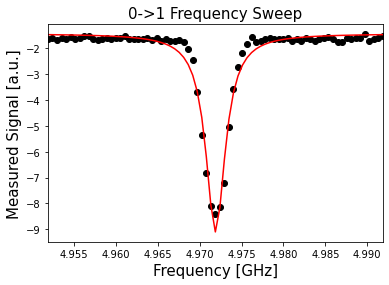

In [20]:
# Note: we are only plotting the real part of the signal
plt.scatter(ground_sweep_freqs/GHz, ground_freq_sweep_data, color='black')
plt.plot(ground_sweep_freqs/GHz, ground_sweep_y_fit, color='red')
plt.xlim([min(ground_sweep_freqs/GHz), max(ground_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep", fontsize=15)
plt.show()

In [21]:
_, cal_qubit_freq, _, _ = ground_sweep_fit_params
print(f"We've updated our qubit frequency estimate from "
      f"{round(default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 4.9718621 GHz to 4.9718784 GHz.


In [22]:
# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [23]:
# Create schedule
rabi_01_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_01_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=drive_amp, 
                                       sigma=drive_sigma, 
                                       name='rabi_01_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(rabi_01_pulse, drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_01_schedules.append(schedule)

In [24]:
# Assemble the schedules into a program
# Note: We drive at the calibrated frequency.
rabi_01_expt_program = assemble(rabi_01_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [25]:
rabi_01_job = backend.run(rabi_01_expt_program)

In [26]:
print(rabi_01_job.job_id())

609994365cd0b0861c6a28a2


In [32]:
rabi_01_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [33]:
# Get the job data (average)
rabi_01_data = get_job_data(rabi_01_job, average=True)

In [34]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

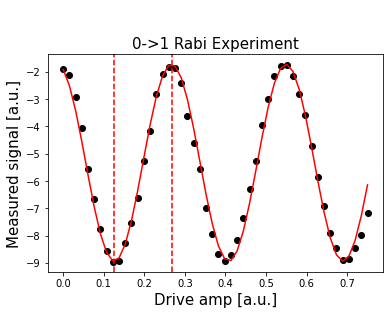

In [35]:
# Note: Only real part of data is plotted
#rabi_01_data = np.real(baseline_remove(rabi_01_data))
rabi_01_data = np.real(rabi_01_data)
(rabi_01_fit_params, 
 rabi_01_y_fit) = fit_function(drive_amps,
                               rabi_01_data, 
                               lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
                               [4, -4, 0.3, 0])

plt.scatter(drive_amps, rabi_01_data, color='black')
plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2] 
# account for phi in computing pi amp
pi_amp_01 = (drive_01_period/2/np.pi) *(np.pi+rabi_01_fit_params[3])

plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('0->1 Rabi Experiment', fontsize=15)
plt.show()

In [36]:
print(f"Pi Amplitude (0->1) = {pi_amp_01}")

Pi Amplitude (0->1) = 0.1261019735183375


In [37]:
#pi_amp_01 = 0.12654915563342325
#cal_qubit_freq = 4.9718997*GHz

In [38]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse01')

In [39]:
# Create the two schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure << int(pi_pulse_01.duration)

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan) 
one_schedule |= measure << one_schedule.duration

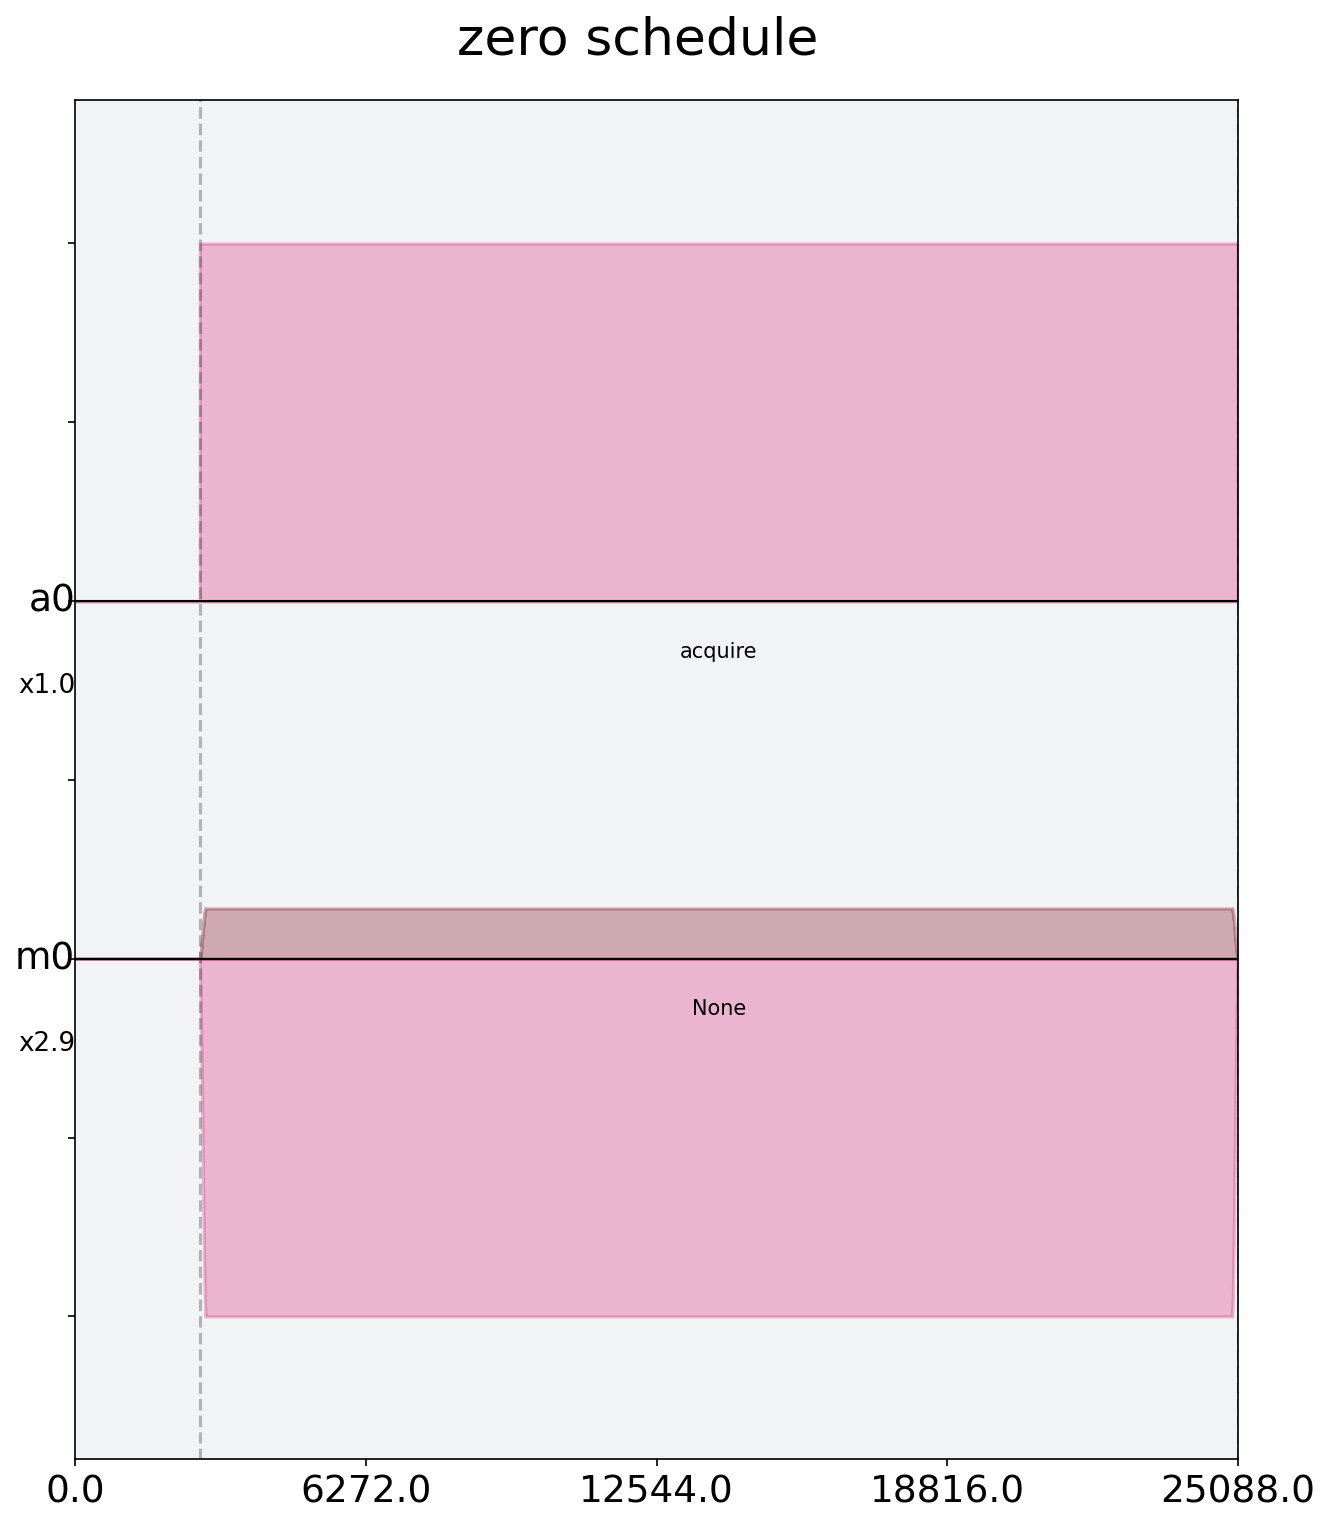

In [40]:
zero_schedule.draw(label=True)

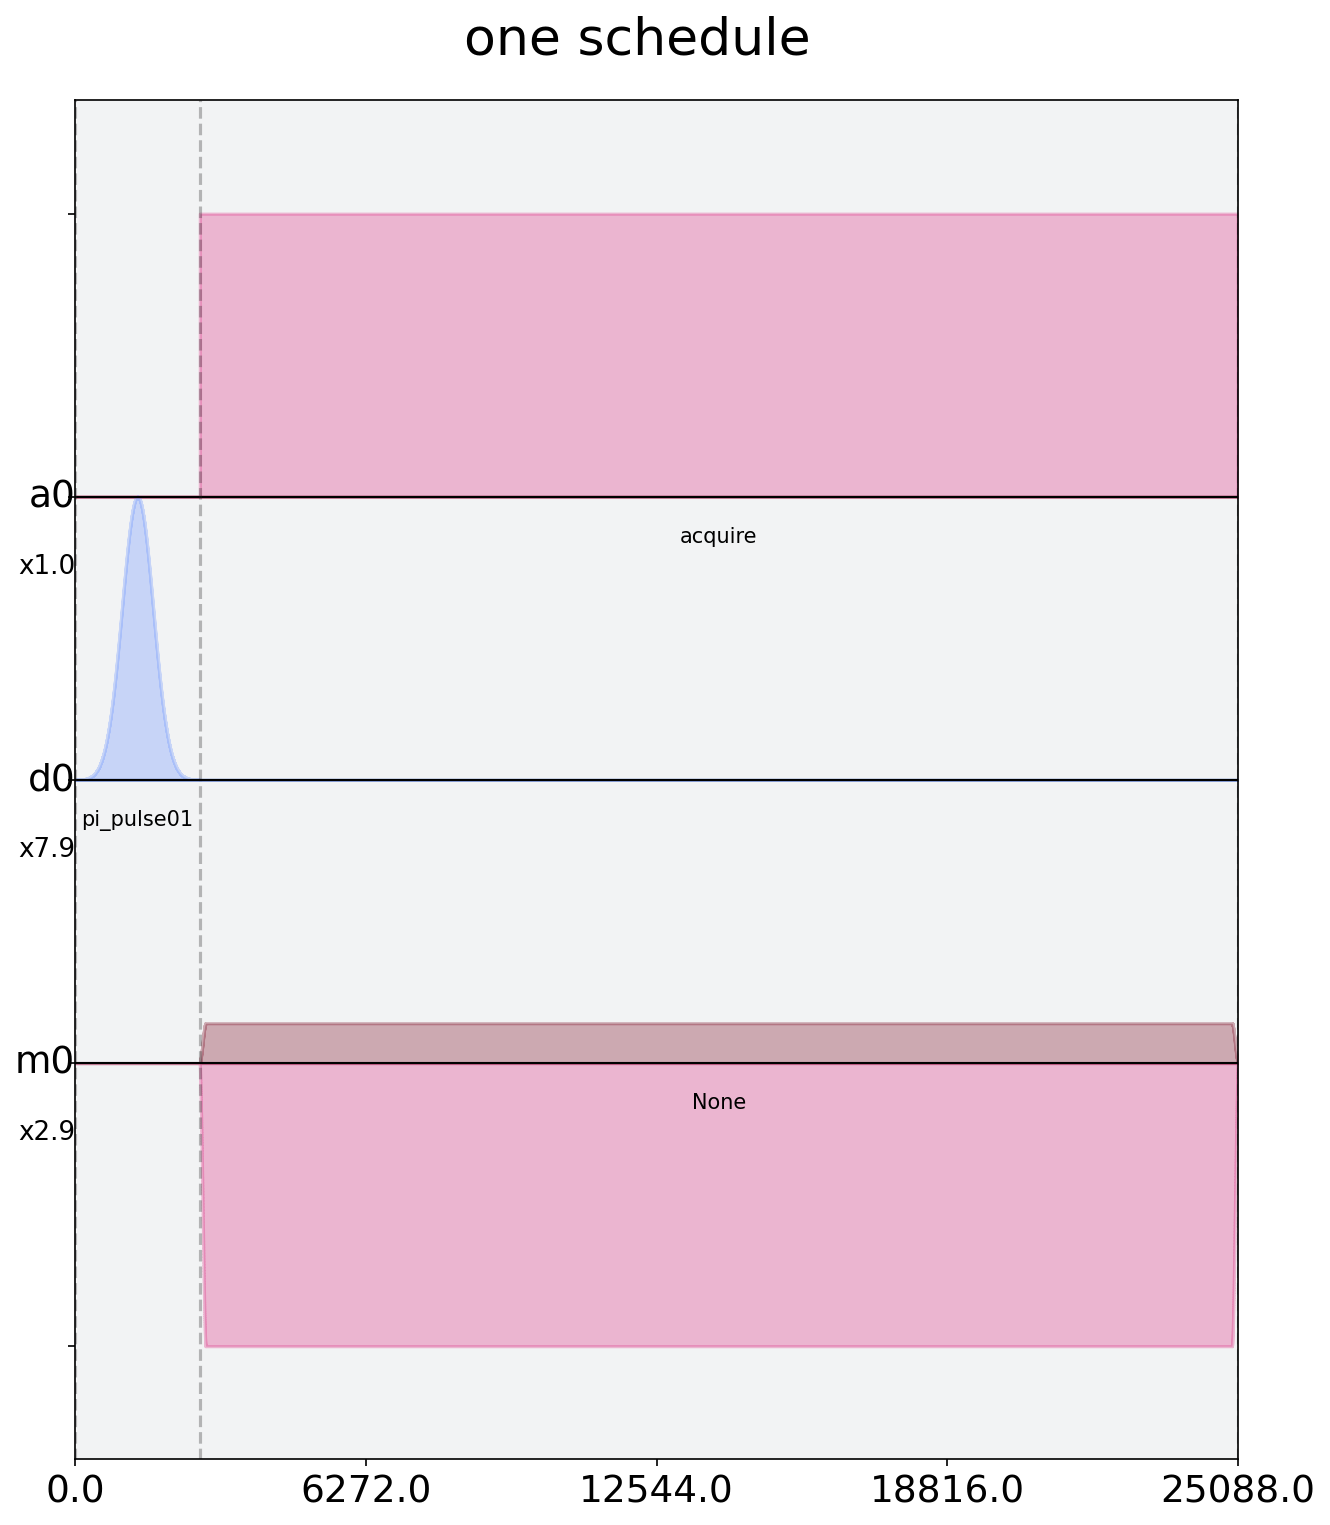

In [41]:
one_schedule.draw(label=True)

In [42]:
# Assemble the schedules into a program
IQ_01_program = assemble([zero_schedule, one_schedule],
                          backend=backend,
                          meas_level=1,
                          meas_return='single',
                          shots=NUM_SHOTS,
                          schedule_los=[{drive_chan: cal_qubit_freq}] * 2)

In [43]:
IQ_01_job = backend.run(IQ_01_program)

In [44]:
print(IQ_01_job.job_id())

609994c1d6b3dbd5ab39cb38


In [47]:
IQ_01_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [48]:
# Get job data (single); split for zero and one
IQ_01_data = get_job_data(IQ_01_job, average=False)
zero_data = IQ_01_data[0]
one_data = IQ_01_data[1]

In [49]:
def IQ_01_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for |0>, |1>. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

    # Plot a large dot for the average result of the zero and one states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

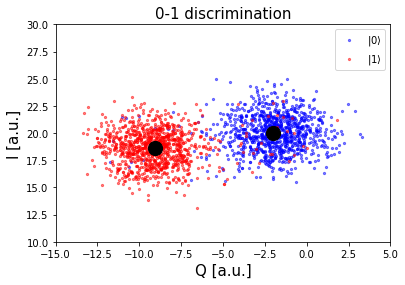

In [50]:
x_min = -15
x_max = 5
y_min = 10
y_max = 30
IQ_01_plot(x_min, x_max, y_min, y_max)

In [51]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-cal_qubit_freq)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = SamplePulse(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband \n pulse')
    
    return sideband_pulse    

In [52]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: cal_qubit_freq}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.571878426456312 GHz to 5.0018784264563125 GHz using 75 frequencies. The drive power is 0.3.


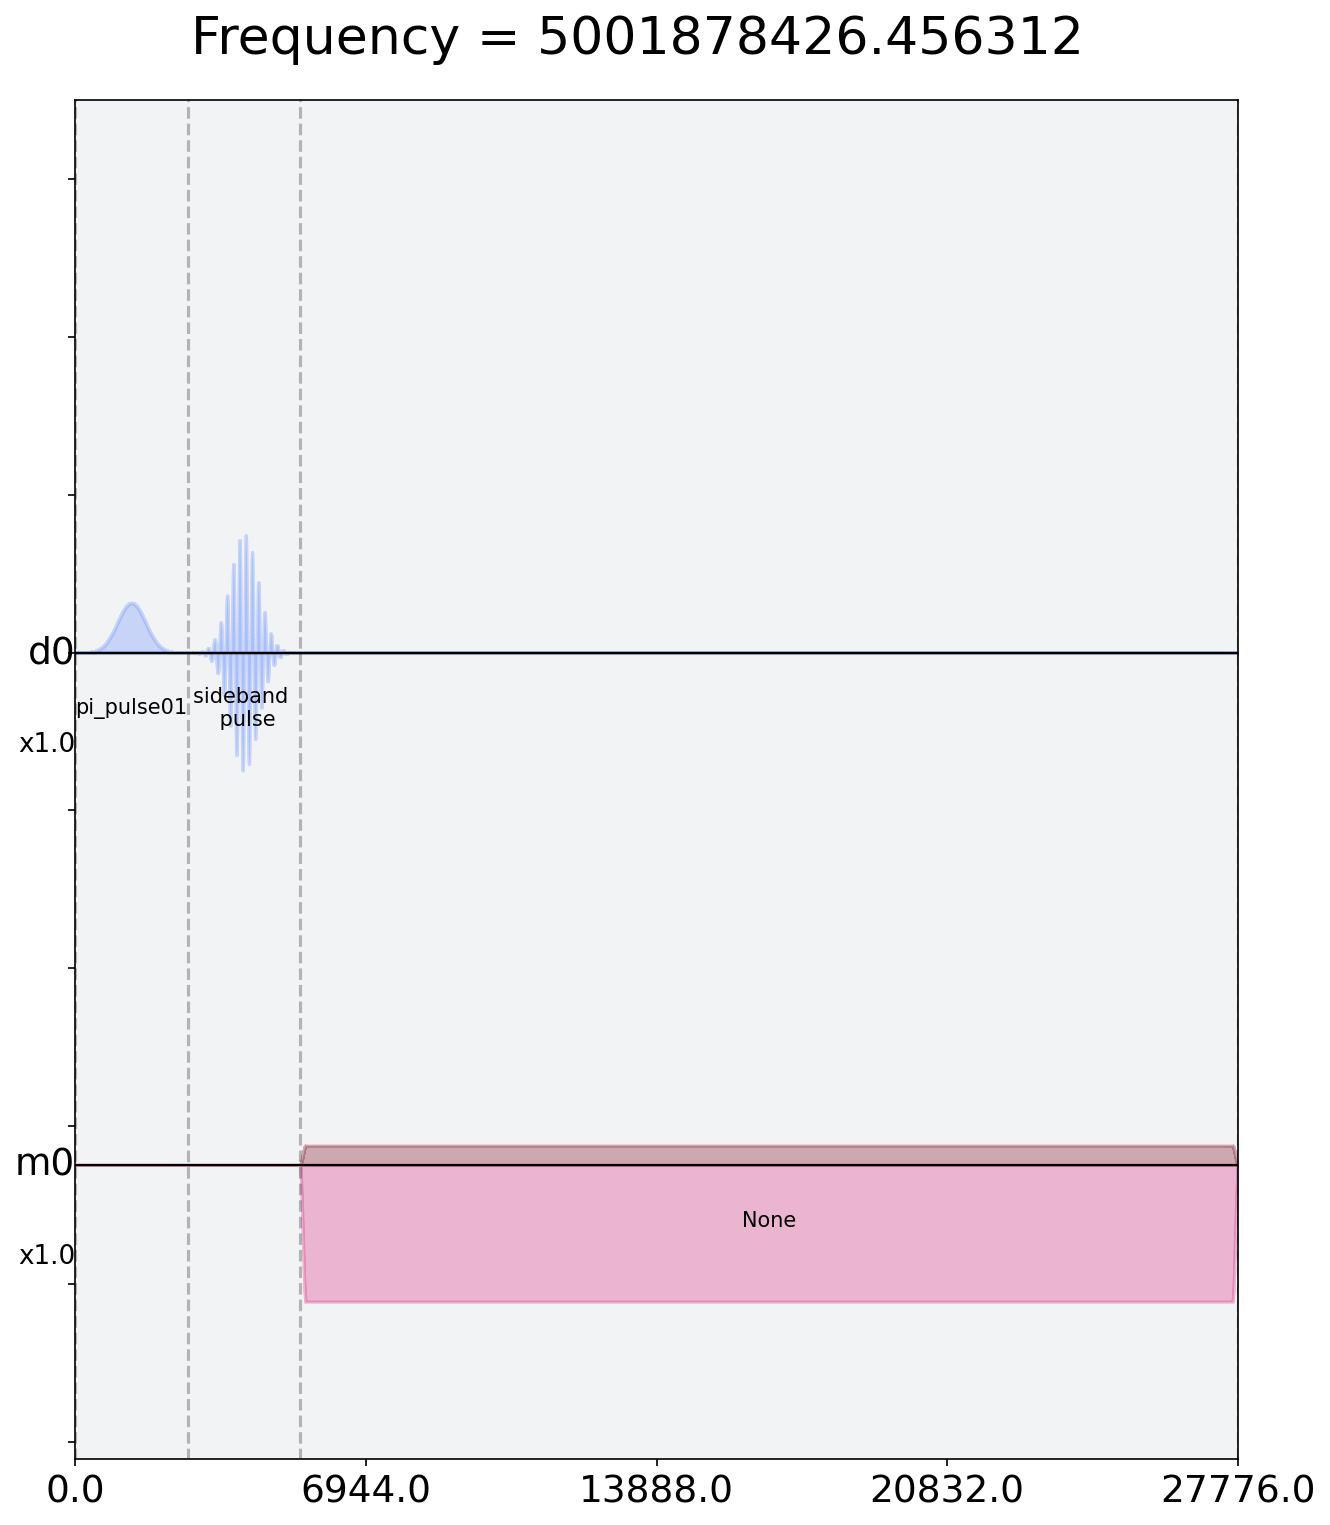

In [53]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
excited_sweep_freqs = cal_qubit_freq + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [54]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)

In [55]:
print(excited_freq_sweep_job.job_id())


60999508f0a79c0f38bb60f0


In [62]:
excited_freq_sweep_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [63]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)

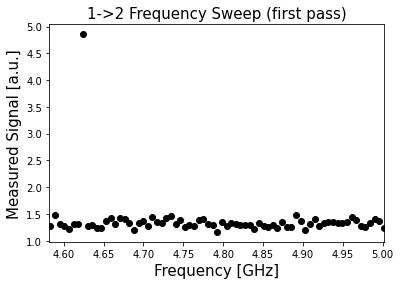

In [64]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

In [65]:
# Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
def rel_maxima(freqs, output_data, height): 
    """
    Prints out relative maxima frequencies in output_data (can see peaks); height gives upper bound (abs val).
    Be sure to set the height properly or the peak will be ignored!
    Args:
        freqs (list): frequency list
        output_data (list): list of resulting signals
        height (float): upper bound (abs val) on a peak
    Returns:
        list: List containing relative maxima frequencies
    """
    peaks, _ = find_peaks(output_data, height)
    print("Freq. dips: ", freqs[peaks])
    return freqs[peaks]

In [66]:
maxima = rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), 2)
approx_12_freq = maxima

Freq. dips:  [4.62417572e+09]


The frequency sweep will go from 4.60417572375361 GHz to 4.64417572375361 GHz using 75 frequencies. The drive power is 0.3.


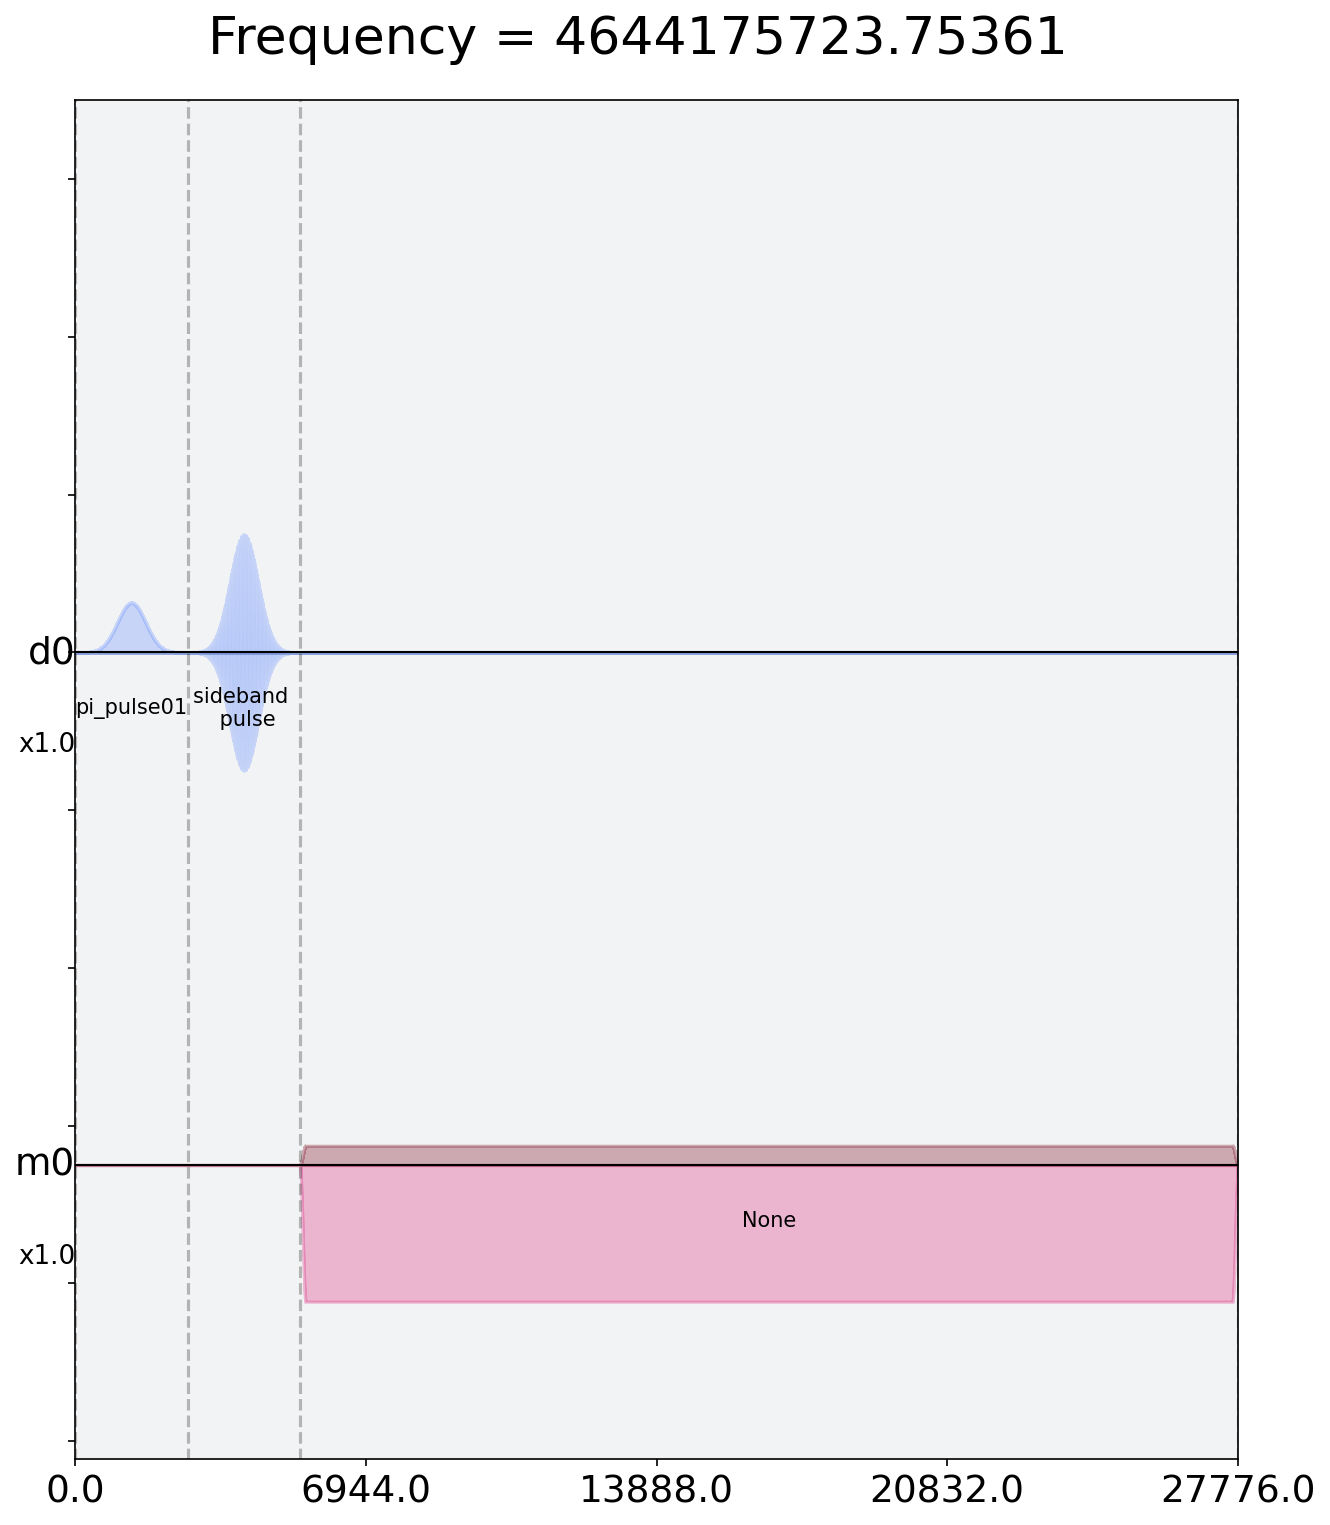

In [67]:
# smaller range refined sweep
num_freqs = 75
refined_excited_sweep_freqs = approx_12_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [68]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)

In [80]:
print(refined_excited_freq_sweep_job.job_id())

609995e6f0a79c6cfdbb60fc


In [81]:
refined_excited_freq_sweep_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [82]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True)

In [83]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.625*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

In [85]:
_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.6236156 GHz.


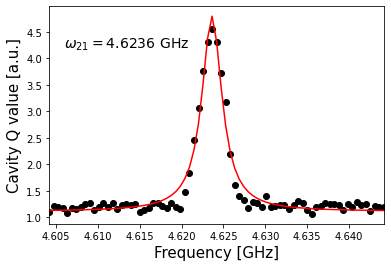

In [92]:
# Note: we are only plotting the real part of the signal
#fig = plt.figure()
fig, ax = plt.subplots()
#fig.subplots_adjust(top=0.85)

ax.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
ax.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
ax.set_xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
ax.set_xlabel("Frequency [GHz]", fontsize=15)
ax.set_ylabel("Cavity Q value [a.u.]", fontsize=15)
#ax.set_title("1->2 Frequency Sweep", fontsize=15)
ax.text(4.606, 4.2, f'$\omega_{{21}}= {round(qubit_12_freq/GHz, 4)}$ GHz', fontsize = 14)
plt.show()
#plt.savefig("12Freqsweep_refined.png")

In [93]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [94]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [95]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [96]:
rabi_12_job = backend.run(rabi_12_expt_program)

In [99]:
print(rabi_12_job.job_id())

609997a8653a6a0ab1887b23


In [102]:
rabi_12_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [103]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

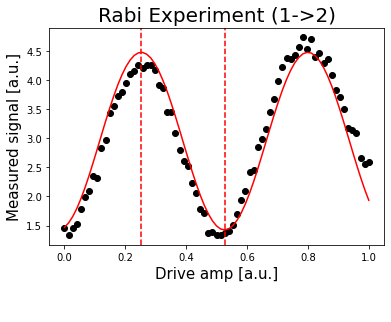

In [104]:
# Note: We only plot the real part of the signal.
#rabi_12_data = np.real(baseline_remove(rabi_12_data))
rabi_12_data = np.real(rabi_12_data)
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_data, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [3, 0.5, 0.6, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [105]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6236156 GHz.
Pi Amplitude (1->2) = 0.25248457167235144


In [106]:
#pi_amp_12 = 0.2506412940597284
#qubit_12_freq = 4.6237516*GHz

In [107]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

In [108]:
# determinant plot with delay beofre measurement
delay_us = 30 # in us
delay_m  = get_closest_multiple_of_16(delay_us * us /dt) - pi_pulse_01.duration - pi_pulse_12.duration + 16
# delay before any pulse
#delay_initial = 100
#delay_initial_m  = get_closest_multiple_of_16(delay_initial * us /dt)

In [109]:
# Create the three schedules

# Ground state schedule
zero_schedule_m = pulse.Schedule(name="zero schedule")
zero_schedule_m |= measure << int(pi_pulse_01.duration) + int(pi_pulse_12.duration) + int(delay_m) #+ int(delay_initial_m)

# Excited state schedule
one_schedule_m = pulse.Schedule(name="one schedule")
one_schedule_m |= pulse.Play(pi_pulse_01, drive_chan) << int(pi_pulse_12.duration)  #+ int(delay_initial_m)
one_schedule_m |= measure << one_schedule_m.duration + int(delay_m)

# Excited state schedule
two_schedule_m = pulse.Schedule(name="two schedule")
two_schedule_m |= pulse.Play(pi_pulse_01, drive_chan) #<< int(delay_initial_m)
two_schedule_m |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule_m.duration 
two_schedule_m |= measure << two_schedule_m.duration + int(delay_m)

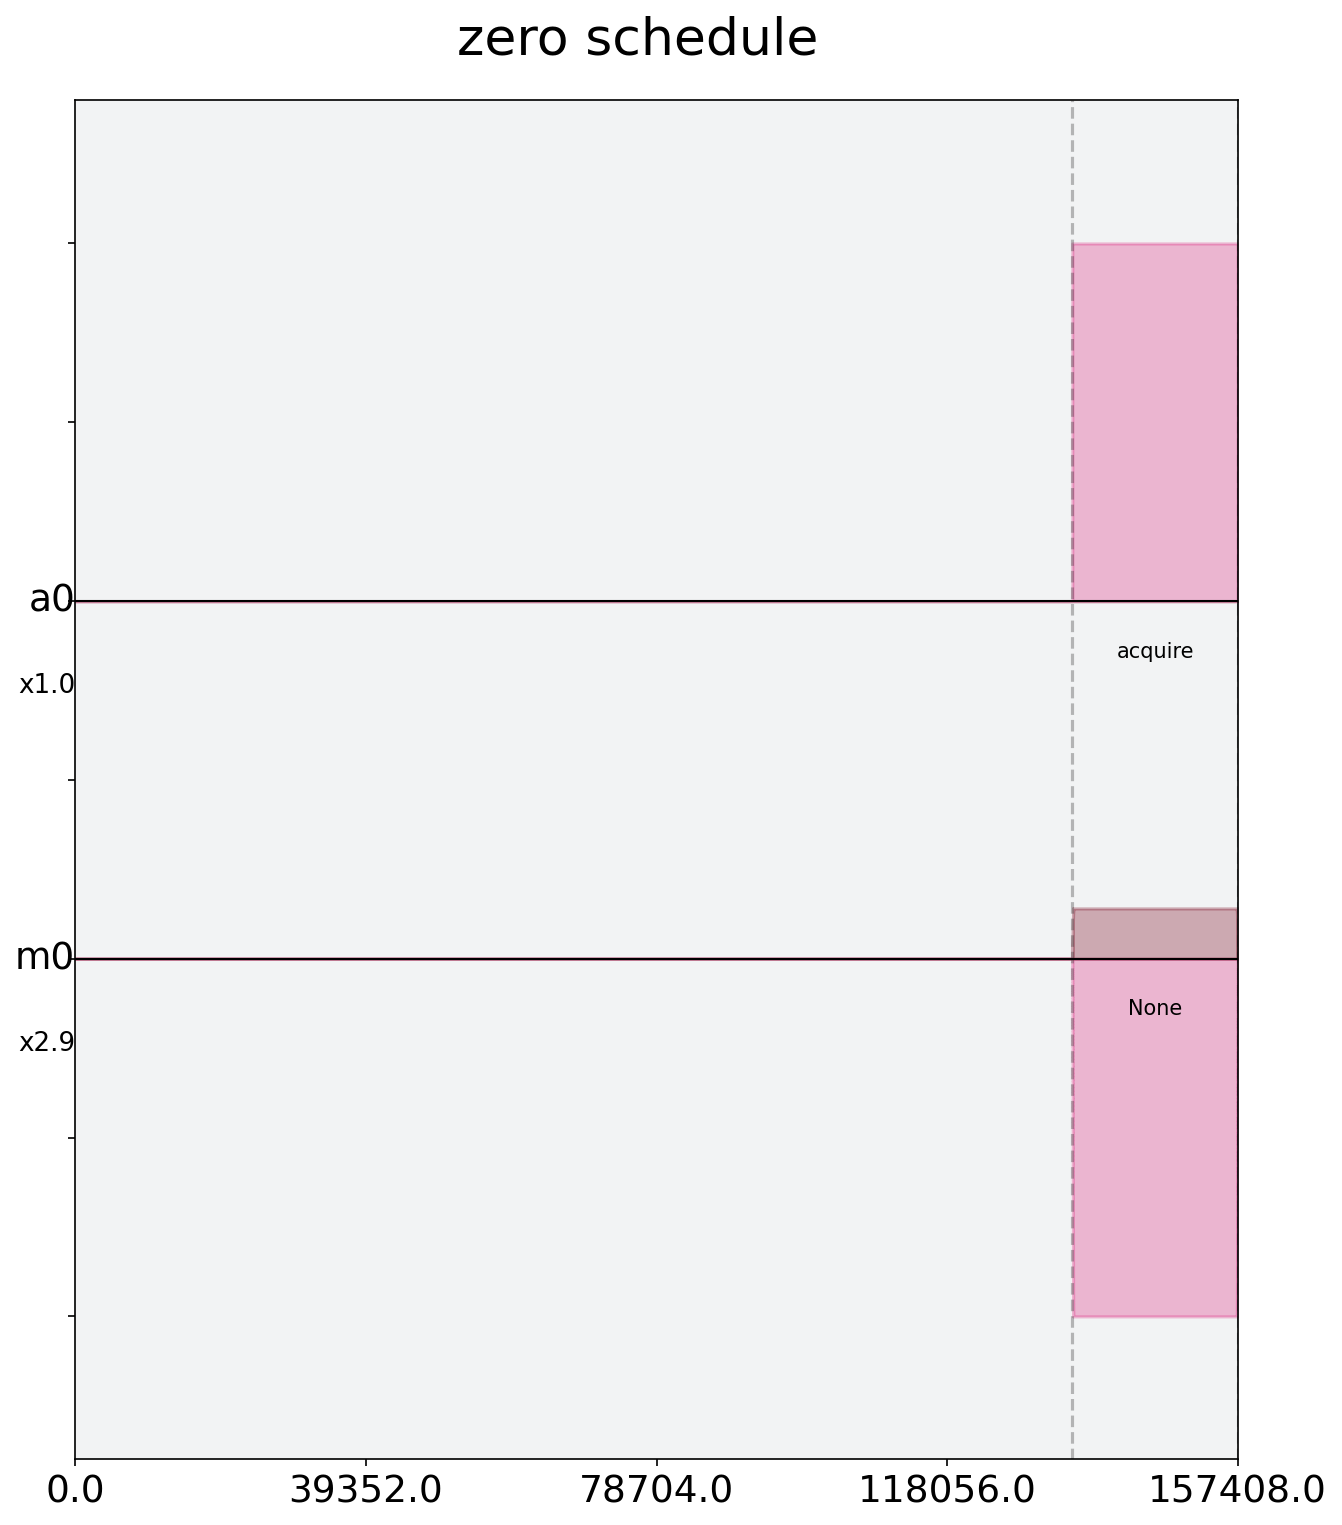

In [110]:
zero_schedule_m.draw(label=True)

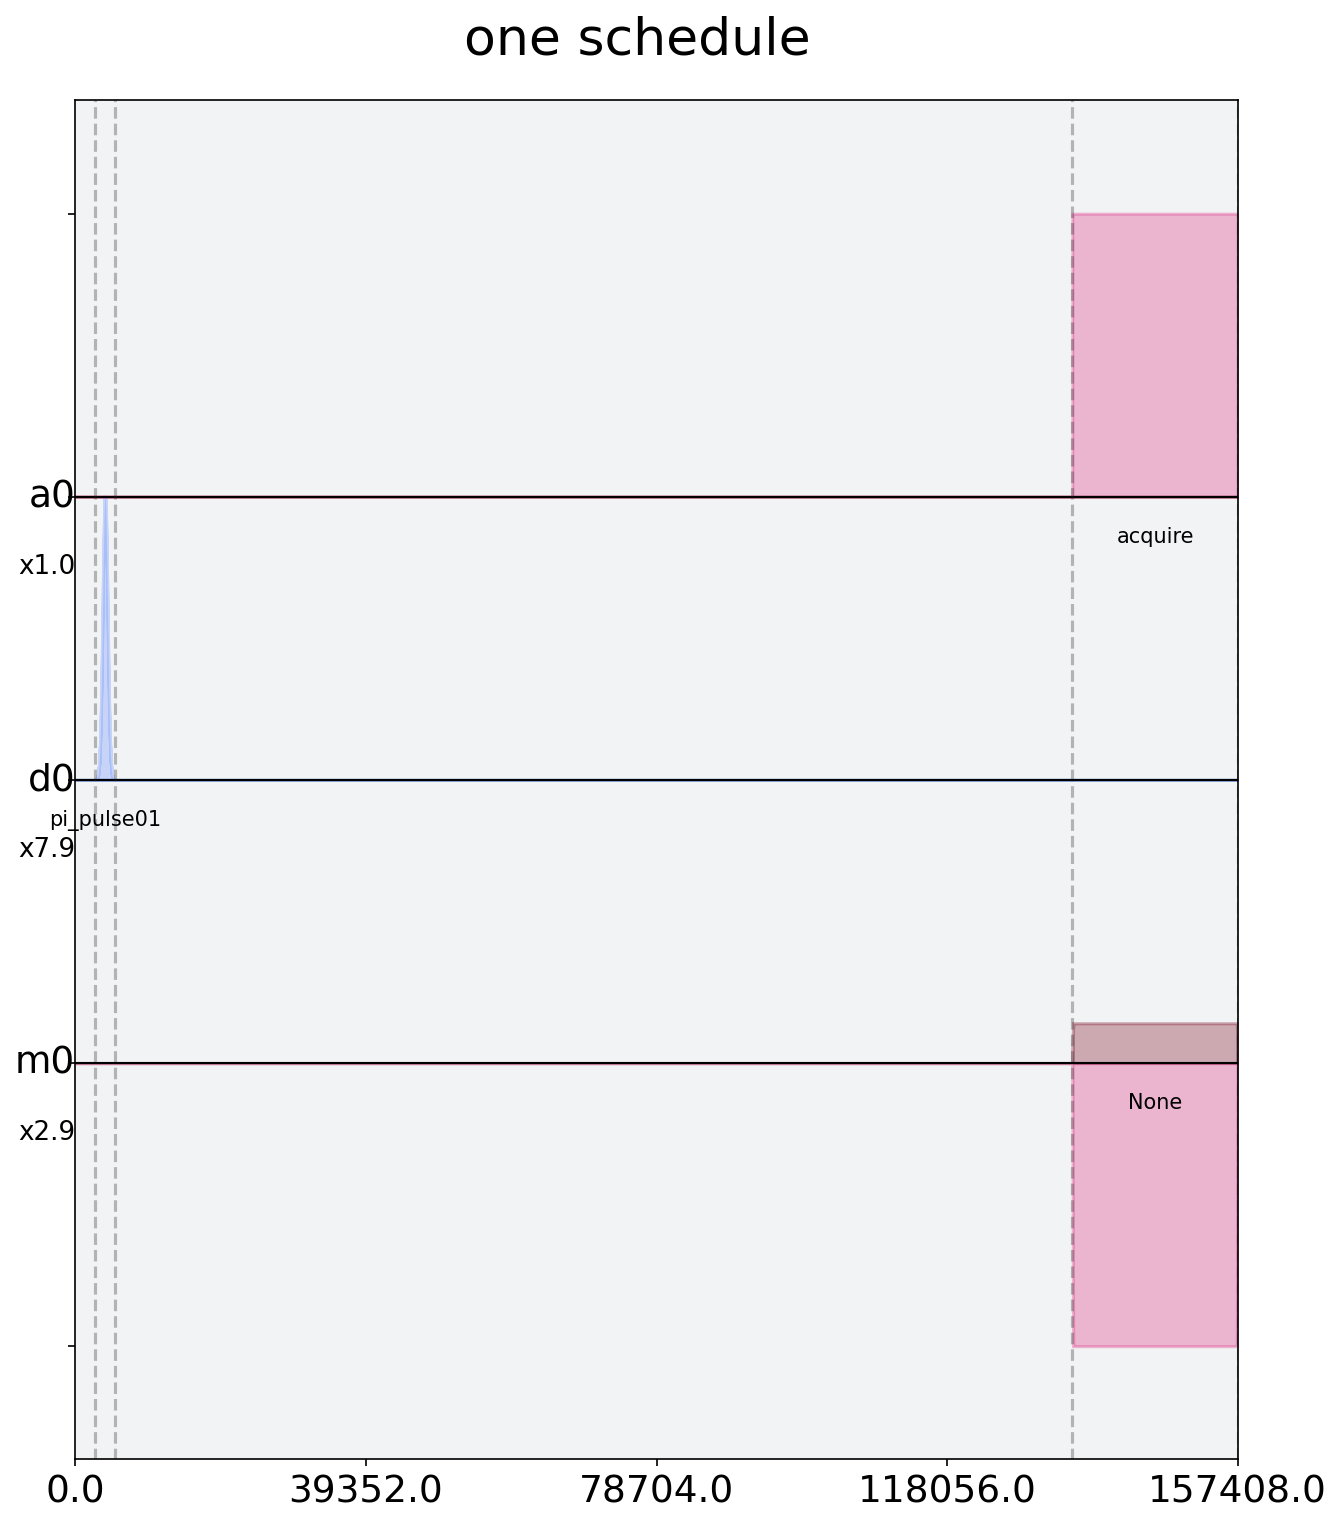

In [111]:
one_schedule_m.draw(label=True)

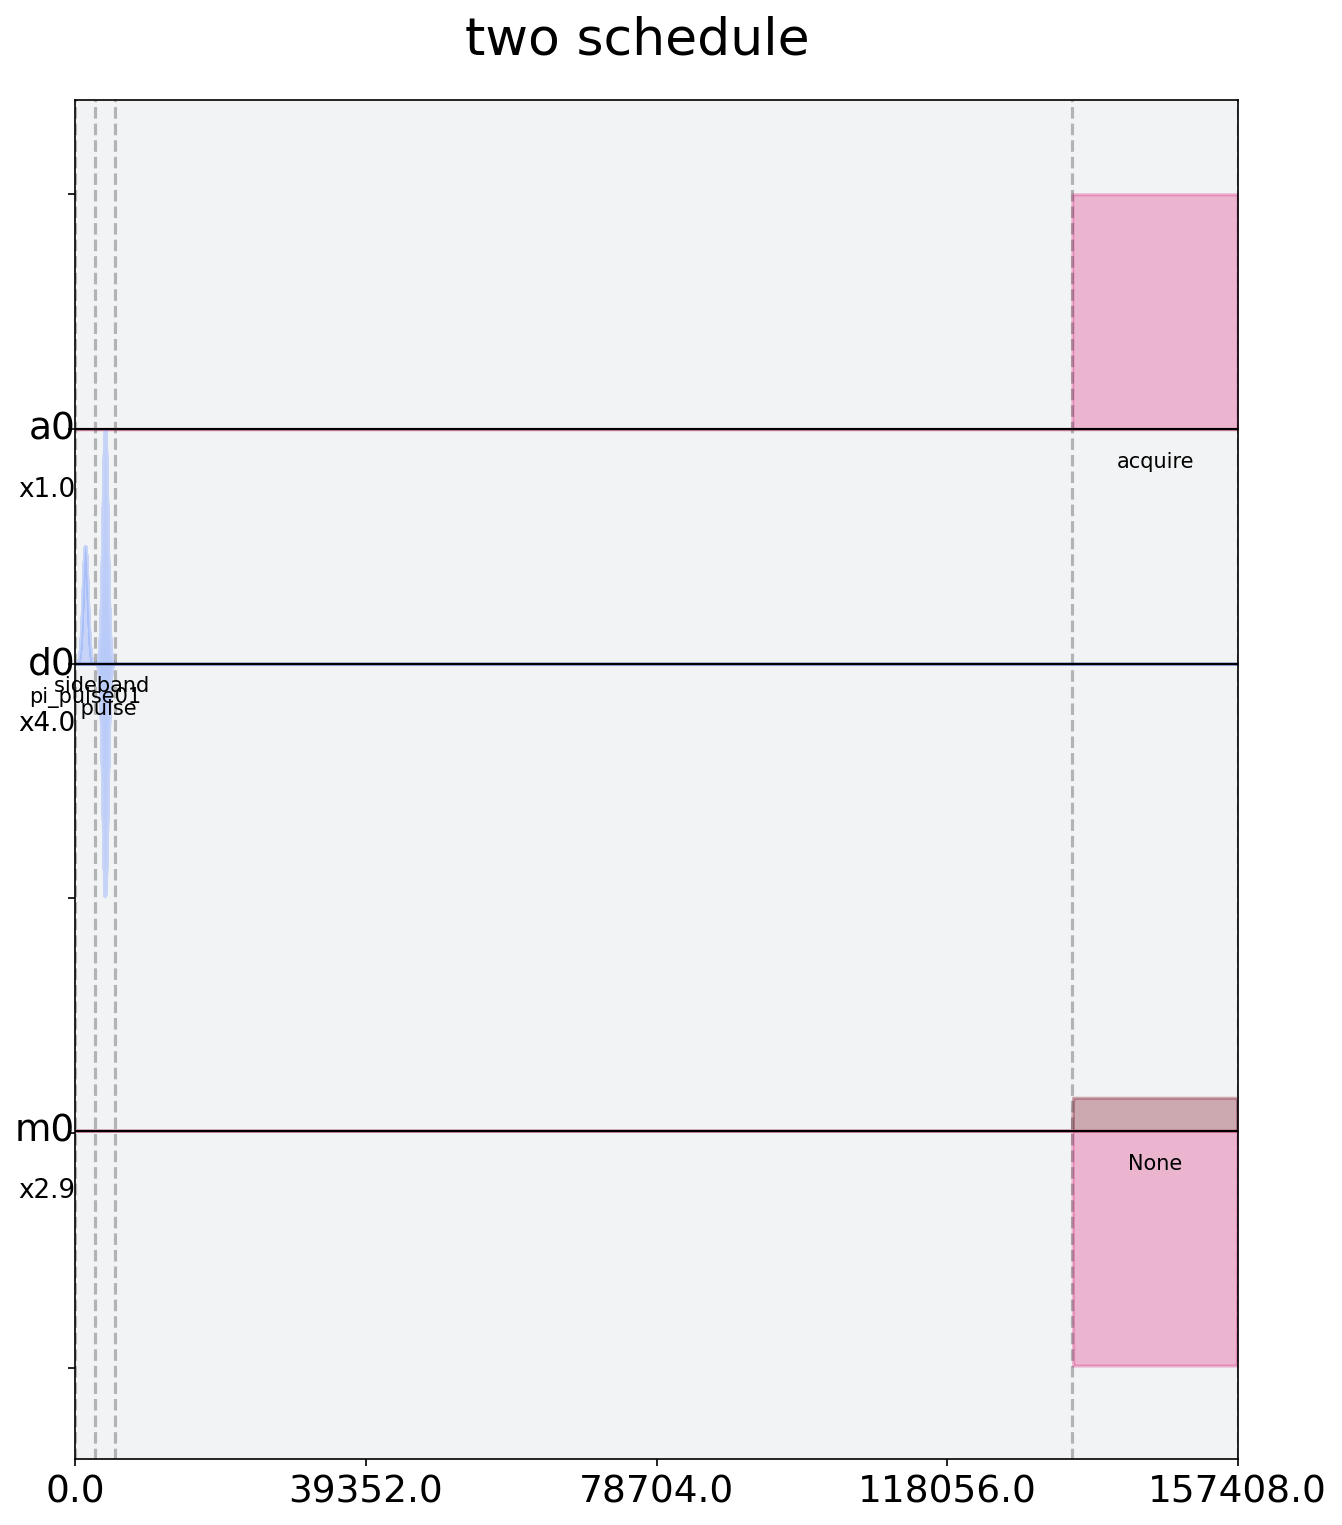

In [112]:
two_schedule_m.draw(label=True)

In [144]:
# Assemble the schedules into a program
IQ_012_program_m = assemble([zero_schedule_m, one_schedule_m, two_schedule_m],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 3)

In [145]:
IQ_012_job_m = backend.run(IQ_012_program_m)

In [146]:
print(IQ_012_job_m.job_id())

609999d65cd0b034766a28d5


In [149]:
IQ_012_job_m.status()

<JobStatus.DONE: 'job has successfully run'>

In [150]:
# Get job data (single); split for zero, one and two
IQ_012_data_m = get_job_data(IQ_012_job_m, average=False)
zero_data = IQ_012_data_m[0]
one_data = IQ_012_data_m[1]
two_data = IQ_012_data_m[2]

In [151]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [152]:
mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
mean_one = np.mean(one_data)
mean_two = np.mean(two_data)
xmean0 = np.real(mean_zero)
ymean0 = np.imag(mean_zero)
xmean1 = np.real(mean_one)
ymean1 = np.imag(mean_one)
xmean2 = np.real(mean_two)
ymean2 = np.imag(mean_two)
print("xmean0 = ", xmean0)
print("ymean0 = ", ymean0)
print("xmean1 = ", xmean1)
print("ymean1 = ", ymean1)
print("xmean2 = ", xmean2)
print("ymean2 = ", ymean2)


xmean0 =  19.05287947485184
ymean0 =  -6.63804747079776
xmean1 =  20.35171281993728
ymean1 =  -0.7518945994253601
xmean2 =  22.82915042557952
ymean2 =  1.6979937859810401


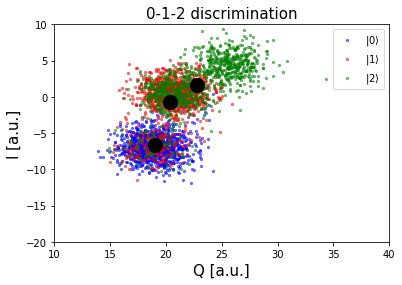

In [153]:
x_min = 10
x_max = 40
y_min = -20
y_max = 10
IQ_012_plot(x_min, x_max, y_min, y_max)


In [154]:
from scipy import stats

In [155]:
from scipy.optimize import leastsq

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = leastsq(errorfunction, params)
    return p

12.881911248584704 25.207482766852095 -13.49756001452032 5.231818613719041


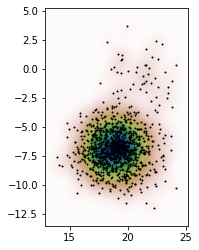

sigma_x = 1.7075871678436305 

sigma_y = 1.6904755136146983 

sigma0 = 1.6990313407291644


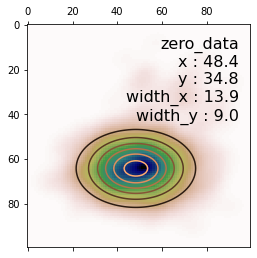

In [156]:
# perform gaussian kernel estimation on zero_data
# 
x = np.real(zero_data)
y = np.imag(zero_data)
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(f), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(x, y, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()


# fit zero_data to a 2D gaussian
plt.matshow(np.rot90(f), cmap=plt.cm.gist_earth_r)

params = fitgaussian(f)
fit = gaussian(*params)

plt.contour(np.rot90(fit(*np.indices(f.shape))), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params

plt.text(0.95, 0.55, """
zero_data
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

xwidth_real = (xmax-xmin)/100*params[3]
print("sigma_x =", xwidth_real,"\n")
ywidth_real = (ymax-ymin)/100*params[4]
print("sigma_y =", ywidth_real,"\n")
sigmaR0 = (xwidth_real + ywidth_real)/2
print("sigma0 =", sigmaR0)

In [157]:
f.shape

(100, 100)

13.865843830030336 27.026551874781184 -13.166468266983424 7.708060097183743


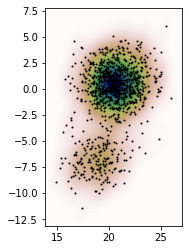

sigma_x =  1.7320444096128356 

sigma_y =  1.9508120145227585 

sigma1 =  1.8414282120677972


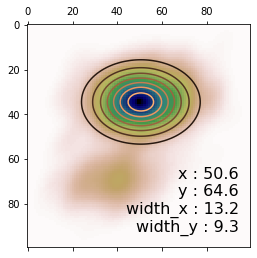

In [158]:
# perform gaussian kernel estimation on one_data
# 
x = np.real(one_data)
y = np.imag(one_data)
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(f), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(x, y, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

# fit zero_data to a 2D gaussian
plt.matshow(np.rot90(f), cmap=plt.cm.gist_earth_r)

params = fitgaussian(f)
fit = gaussian(*params)

plt.contour(np.rot90(fit(*np.indices(f.shape))), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

xwidth_real = (xmax-xmin)/100*params[3]
print("sigma_x = ", xwidth_real,"\n")
ywidth_real = (ymax-ymin)/100*params[4]
print("sigma_y = ", ywidth_real,"\n")
sigmaR1 = (xwidth_real + ywidth_real)/2
print("sigma1 = ", sigmaR1)

In [159]:
# eliminate data that belongs to the other two circles
two_data_new = [value for value in two_data if ((np.real(value)-xmean1)**2 + (np.imag(value)-ymean1)**2)>(1*sigmaR1)**2]   
two_data_new = [value for value in two_data_new if ((np.real(value)-xmean0)**2 + (np.imag(value)-ymean0)**2)>(1*sigmaR0)**2]

12.946770891898879 36.29852955508736 -12.208448968065024 12.208259721068544


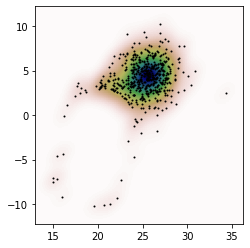

sigma_x = 1.993993220330798 

sigma_y = 1.8879407061639237 

sigma2 = 1.940966963247361


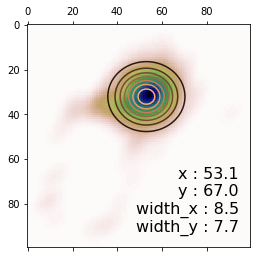

In [160]:
# perform gaussian kernel estimation on two_data
# 
x = np.real(two_data_new)
y = np.imag(two_data_new)
#x = np.real(two_data)
#y = np.imag(two_data)
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(f), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(x, y, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

# fit zero_data to a 2D gaussian
plt.matshow(np.rot90(f), cmap=plt.cm.gist_earth_r)

params = fitgaussian(f)
fit = gaussian(*params)

plt.contour(np.rot90(fit(*np.indices(f.shape))), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

xwidth_real = (xmax-xmin)/100*params[3]
print("sigma_x =", xwidth_real,"\n")
ywidth_real = (ymax-ymin)/100*params[4]
print("sigma_y =", ywidth_real,"\n")
sigmaR2 = (xwidth_real + ywidth_real)/2
print("sigma2 =", sigmaR2)

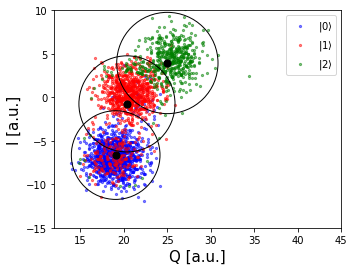

In [161]:
fig, ax = plt.subplots()
# zero data plotted in blue
plt.scatter(np.real(zero_data), np.imag(zero_data), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
# one data plotted in red
plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
# two data plotted in green
plt.scatter(np.real(two_data_new), np.imag(two_data_new), 
#plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

# Plot a large dot for the average result of the 0, 1 and 2 states.
mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
mean_one = np.mean(one_data)
#mean_two = np.mean(two_data)
mean_two = np.mean(two_data_new)
plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=50, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=50, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=50, cmap='viridis', c='black',alpha=1.0)

C0 = plt.Circle( (np.real(mean_zero), np.imag(mean_zero)), 3*sigmaR0 , fill = False )
C1 = plt.Circle( (np.real(mean_one), np.imag(mean_one)), 3*sigmaR1 , fill = False )
C2 = plt.Circle( (np.real(mean_two), np.imag(mean_two)), 3*sigmaR2 , fill = False )
  
ax.set_aspect( 1 )
ax.add_artist( C0 )
ax.add_artist( C1 )
ax.add_artist( C2 )

plt.xlim(12, 45)
plt.ylim(-15,10)
plt.legend()
plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
#plt.title("0-1-2 discrimination", fontsize=15)
plt.show()
fig.savefig('state2_QIplot.png')